In [9]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import logging
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf

tf.get_logger().setLevel(logging.ERROR)

from tensorflow.keras.callbacks import ModelCheckpoint

from src.segmentation.image import Preprocessor
from src.segmentation.model import (
    CosineAnnealingLearningRateSchedule,
    SegmentationModel,
)
from src.utils import (Const, Estimator)
from numba import jit

# 1. Загрузка данных

In [10]:
def load_samples(folder_path):
    samples = []

    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        file_paths = os.listdir(folder_path)
        for i in tqdm.trange(len(file_paths)):
            path = os.path.join(folder_path, file_paths[i])
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE) / 255.
            samples.append(sample.reshape(Const.IMG_SIZE, Const.IMG_SIZE, 1))

    return np.array(samples)

In [11]:
imgs_ct = load_samples(Const.CT_IMAGES_PATH)
imgs_lungs = load_samples(Const.LUNGS_IMAGES_PATH)
imgs_covid = load_samples(Const.COVID_IMAGES_PATH)

100%|██████████| 1614/1614 [00:01<00:00, 1271.73it/s]


In [12]:
print(f'{imgs_ct.shape=}')
print(f'{imgs_lungs.shape=}')
print(f'{imgs_covid.shape=}')

print(f'{imgs_ct.min()=} {imgs_ct.max()=}')
print(f'{imgs_lungs.min()=} {imgs_lungs.max()=}')
print(f'{imgs_covid.min()=} {imgs_covid.max()=}')

imgs_ct.shape=(1614, 256, 256, 1)
imgs_lungs.shape=(1614, 256, 256, 1)
imgs_covid.shape=(1614, 256, 256, 1)
imgs_ct.min()=0.0 imgs_ct.max()=1.0
imgs_lungs.min()=0.0 imgs_lungs.max()=1.0
imgs_covid.min()=0.0 imgs_covid.max()=1.0


## Перемешивание данных

In [13]:
imgs_ct, imgs_lungs, imgs_covid = shuffle(imgs_ct, imgs_lungs, imgs_covid)

# 2. Разбиение на выборки

In [14]:
TRAIN_SIZE = int(0.8 * imgs_ct.shape[0])
TEST_SIZE = int(0.1 * imgs_ct.shape[0])

train_x, train_lungs, train_covid = (
    imgs_ct[:TRAIN_SIZE],
    imgs_lungs[:TRAIN_SIZE],
    imgs_covid[:TRAIN_SIZE],
)
valid_x, valid_lungs, valid_covid = (
    imgs_ct[TRAIN_SIZE:],
    imgs_lungs[TRAIN_SIZE:],
    imgs_covid[TRAIN_SIZE:],
)
test_x, test_lungs, test_covid = (
    imgs_ct[:TEST_SIZE],
    imgs_lungs[:TEST_SIZE],
    imgs_covid[:TEST_SIZE],
)

print(f'{train_x.shape=}, {train_lungs.shape=}, {train_covid.shape=}')
print(f'{valid_x.shape=}, {valid_lungs.shape=}, {valid_covid.shape=}')
print(f'{test_x.shape=}, {test_lungs.shape=}, {test_covid.shape=}')

del imgs_ct, imgs_lungs, imgs_covid
del TRAIN_SIZE, TEST_SIZE

train_x.shape=(1291, 256, 256, 1), train_lungs.shape=(1291, 256, 256, 1), train_covid.shape=(1291, 256, 256, 1)
valid_x.shape=(323, 256, 256, 1), valid_lungs.shape=(323, 256, 256, 1), valid_covid.shape=(323, 256, 256, 1)
test_x.shape=(161, 256, 256, 1), test_lungs.shape=(161, 256, 256, 1), test_covid.shape=(161, 256, 256, 1)


# 3. Обучение модели

Мы будем использовать коэффициент Дайса в качестве метрики для сегментации COVID 19.

$$Dice=\frac{2 TP}{2 TP+FN+FP}$$

где $TP$, $FN$ и $FP$ соответствуют истинно положительному, ложно отрицательному и ложно положительному значениям, соответственно.

In [15]:
EPOCHS = 50
BATCH_SIZE = 16
FROM_SCRATCH = False

In [16]:
lungs_segmentation = SegmentationModel(train_x.shape[1:])
covid_segmentation = SegmentationModel(train_x.shape[1:])

lungs_segmentation.compile()
covid_segmentation.compile()

if not FROM_SCRATCH:
    if os.path.exists(Const.LUNGS_MODEL_WEIGHTS_PATH) and os.path.exists(Const.COVID_MODEL_WEIGHTS_PATH):
        try:
            lungs_segmentation.load_weights(Const.LUNGS_MODEL_WEIGHTS_PATH)
            covid_segmentation.load_weights(Const.COVID_MODEL_WEIGHTS_PATH)
        except Exception as e:
            e.with_traceback()

In [11]:
def load_history(csv_path):
    columns = ['loss', 'val_loss', 'dice', 'val_dice']
    df = pd.read_csv(csv_path, index_col=False, names=columns, header=0)

    res = dict()
    res['epochs'] = len(df.loss)
    res['loss'] = df.loss.to_list()
    res['val_loss'] = df.val_loss.to_list()
    res['dice'] = df.dice.to_list()
    res['val_dice'] = df.val_dice.to_list()

    return res


def save_history(history, csv_path):
    columns = ['loss', 'val_loss', 'dice', 'val_dice']

    if os.path.exists(csv_path) and os.path.isfile(csv_path):
        history_csv = pd.read_csv(csv_path, index_col=False, names=columns, header=0)
    else:
        history_csv = pd.DataFrame([], columns=columns)

    values = []

    for epoch in history.epoch:
        values.append([
            history.history['loss'][epoch],
            history.history['val_loss'][epoch],
            history.history['dice'][epoch],
            history.history['val_dice'][epoch],
        ]
        )

    df = pd.DataFrame(values, columns=columns)

    history_csv = history_csv.append(df, ignore_index=True)
    history_csv.to_csv(csv_path, index=False)

## Легкие

In [10]:
lungs_history = lungs_segmentation.fit(
        X=train_x,
        Y=train_lungs,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(valid_x, valid_lungs),
        callbacks=[
            ModelCheckpoint(
                    filepath=Const.LUNGS_MODEL_WEIGHTS_PATH,
                    monitor='val_dice',
                    mode='max',
                    save_best_only=True,
                    save_weights_only=True,
            ),
            CosineAnnealingLearningRateSchedule(
                    n_epochs=EPOCHS,
                    n_cycles=EPOCHS / 25,
                    lrate_max=5e-5,
            ),
        ],
        verbose=2,
)
save_history(lungs_history, Const.LUNGS_HISTORY_PATH)

Epoch 1/50
81/81 - 30s - loss: 0.3248 - dice: 0.5877 - val_loss: 0.6380 - val_dice: 0.1473
Epoch 2/50
81/81 - 27s - loss: 0.1010 - dice: 0.8755 - val_loss: 0.8890 - val_dice: 0.0138
Epoch 3/50
81/81 - 27s - loss: 0.0647 - dice: 0.9220 - val_loss: 1.0268 - val_dice: 0.0044
Epoch 4/50
81/81 - 27s - loss: 0.0479 - dice: 0.9419 - val_loss: 1.0858 - val_dice: 0.0132
Epoch 5/50
81/81 - 27s - loss: 0.0393 - dice: 0.9525 - val_loss: 0.9750 - val_dice: 0.1412
Epoch 6/50
81/81 - 28s - loss: 0.0349 - dice: 0.9577 - val_loss: 0.7272 - val_dice: 0.3875
Epoch 7/50
81/81 - 28s - loss: 0.0321 - dice: 0.9615 - val_loss: 0.2547 - val_dice: 0.7955
Epoch 8/50
81/81 - 28s - loss: 0.0291 - dice: 0.9649 - val_loss: 0.1346 - val_dice: 0.8830
Epoch 9/50
81/81 - 28s - loss: 0.0277 - dice: 0.9665 - val_loss: 0.0539 - val_dice: 0.9480
Epoch 10/50
81/81 - 28s - loss: 0.0253 - dice: 0.9695 - val_loss: 0.0363 - val_dice: 0.9632
Epoch 11/50
81/81 - 27s - loss: 0.0248 - dice: 0.9703 - val_loss: 0.0406 - val_dice: 0.95

## COVID 19

In [11]:
covid_history = covid_segmentation.fit(
        X=train_x,
        Y=train_covid,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(valid_x, valid_covid),
        callbacks=[
            ModelCheckpoint(
                    filepath=Const.COVID_MODEL_WEIGHTS_PATH,
                    monitor='val_dice',
                    mode='max',
                    save_best_only=True,
                    save_weights_only=True,
            ),
            CosineAnnealingLearningRateSchedule(
                    n_epochs=EPOCHS,
                    n_cycles=EPOCHS / 25,
                    lrate_max=5e-5,
            ),
        ],
        verbose=2,
)
save_history(covid_history, Const.COVID_HISTORY_PATH)


Epoch 1/50
81/81 - 28s - loss: 0.5085 - dice: 0.0936 - val_loss: 0.5479 - val_dice: 0.0084
Epoch 2/50
81/81 - 27s - loss: 0.3346 - dice: 0.3942 - val_loss: 0.5567 - val_dice: 0.0041
Epoch 3/50
81/81 - 27s - loss: 0.2779 - dice: 0.5059 - val_loss: 0.5721 - val_dice: 0.0034
Epoch 4/50
81/81 - 27s - loss: 0.2468 - dice: 0.5645 - val_loss: 0.5847 - val_dice: 0.0037
Epoch 5/50
81/81 - 28s - loss: 0.2283 - dice: 0.5973 - val_loss: 0.5535 - val_dice: 0.0603
Epoch 6/50
81/81 - 28s - loss: 0.2149 - dice: 0.6214 - val_loss: 0.4290 - val_dice: 0.2614
Epoch 7/50
81/81 - 28s - loss: 0.2027 - dice: 0.6445 - val_loss: 0.3264 - val_dice: 0.4317
Epoch 8/50
81/81 - 28s - loss: 0.1945 - dice: 0.6581 - val_loss: 0.2171 - val_dice: 0.6131
Epoch 9/50
81/81 - 28s - loss: 0.1873 - dice: 0.6712 - val_loss: 0.2167 - val_dice: 0.6198
Epoch 10/50
81/81 - 28s - loss: 0.1785 - dice: 0.6867 - val_loss: 0.1934 - val_dice: 0.6567
Epoch 11/50
81/81 - 27s - loss: 0.1741 - dice: 0.6951 - val_loss: 0.2055 - val_dice: 0.63

In [12]:
lungs_history = load_history(Const.LUNGS_HISTORY_PATH)
covid_history = load_history(Const.COVID_HISTORY_PATH)

In [15]:
def plot_history(history, title):
    plt.style.use('ggplot')

    _, axes = plt.subplots(ncols=2, figsize=(16, 9))
    plt.title(title)

    axes[0].plot(history['dice'], color='black', label='Обучение')
    axes[0].plot(history['val_dice'], color='limegreen', label='Валидация')
    axes[0].set_ylabel('Коэффициент Дайса')
    axes[0].set_xlabel('Эпоха')
    axes[0].legend(loc='best')

    axes[1].plot(history['loss'], color='black', label='Обучение')
    axes[1].plot(history['val_loss'], color='limegreen', label='Валидация')
    axes[1].set_ylabel('Метрика Дайса')
    axes[1].set_xlabel('Эпоха')
    axes[1].legend(loc='best')

    plt.show()

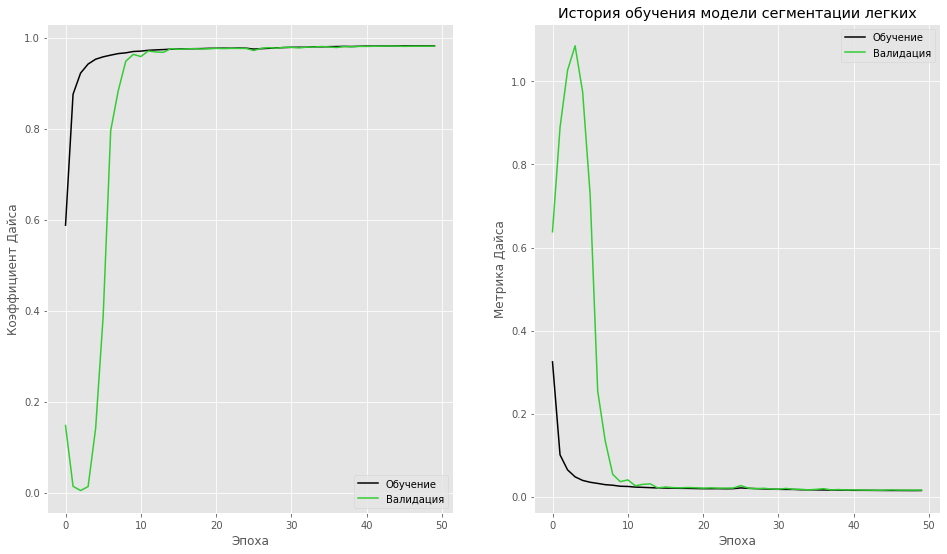

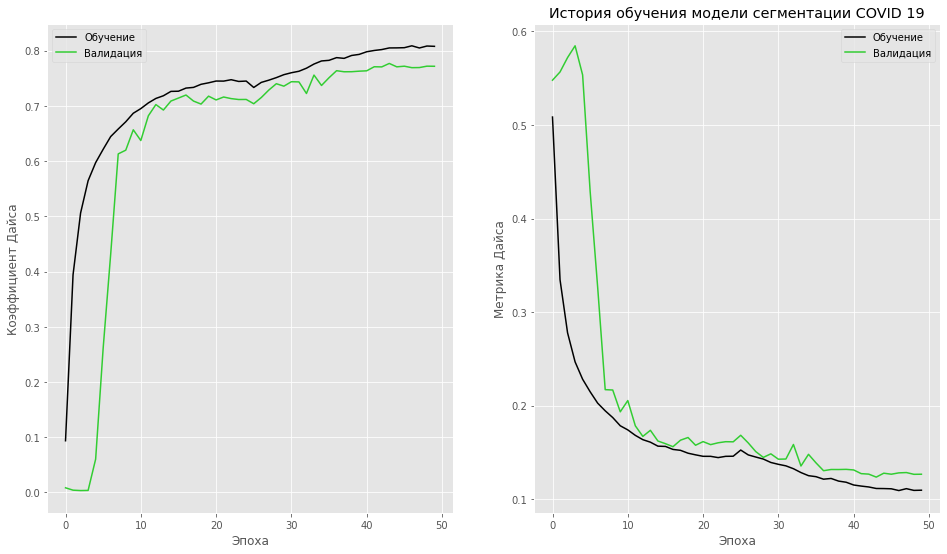

In [16]:
plot_history(lungs_history, 'История обучения модели сегментации легких')
plot_history(covid_history, 'История обучения модели сегментации COVID 19')

del BATCH_SIZE, EPOCHS, FROM_SCRATCH
del lungs_history, covid_history

# 7. Тестирование

[112, 102, 74, 152, 154]


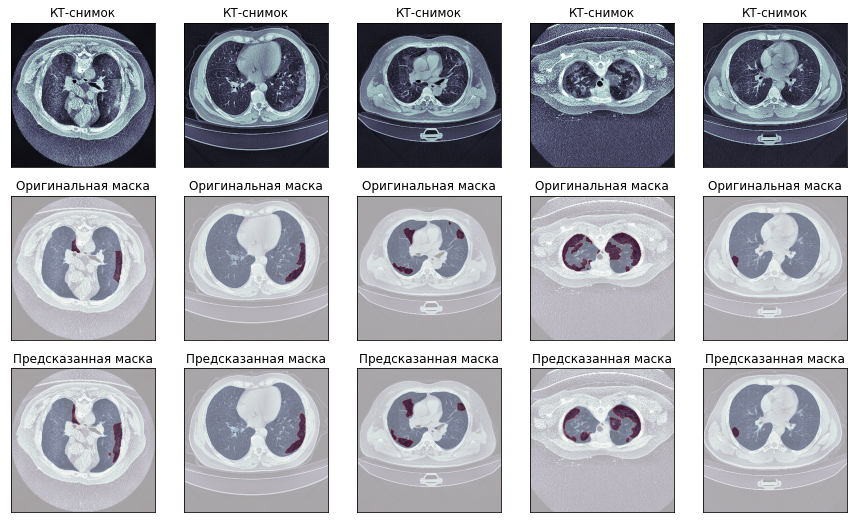

In [17]:
lungs_segmentation.load_weights(Const.LUNGS_MODEL_WEIGHTS_PATH)
covid_segmentation.load_weights(Const.COVID_MODEL_WEIGHTS_PATH)

lungs_prediction = lungs_segmentation.predict(test_x)
covid_prediction = covid_segmentation.predict(test_x)

indices = random.choices(range(len(test_x)), k=5)
_, axes = plt.subplots(3, 5, figsize=(15, 9))

print(indices)

for ii, idx in enumerate(indices):
    axes[0, ii].imshow(test_x[idx], cmap='bone')
    axes[0, ii].set_title('КТ-снимок')
    axes[0, ii].set_xticks([])
    axes[0, ii].set_yticks([])
    plt.grid()

    axes[1, ii].imshow(test_x[idx], cmap='bone')
    axes[1, ii].imshow(test_lungs[idx], alpha=0.4, cmap='Blues')
    axes[1, ii].imshow(test_covid[idx], alpha=0.4, cmap='Reds')
    axes[1, ii].set_title('Оригинальная маска')
    axes[1, ii].set_xticks([])
    axes[1, ii].set_yticks([])
    plt.grid()

    axes[2, ii].imshow(test_x[idx], cmap='bone')
    axes[2, ii].imshow(lungs_prediction[idx], alpha=0.4, cmap='Blues')
    axes[2, ii].imshow(covid_prediction[idx], alpha=0.4, cmap='Reds')
    axes[2, ii].set_title('Предсказанная маска')
    axes[2, ii].set_xticks([])
    axes[2, ii].set_yticks([])
    plt.grid()

del lungs_segmentation, covid_segmentation
del indices, axes, ii, idx
del train_x, train_lungs, train_covid, valid_x, valid_lungs, valid_covid

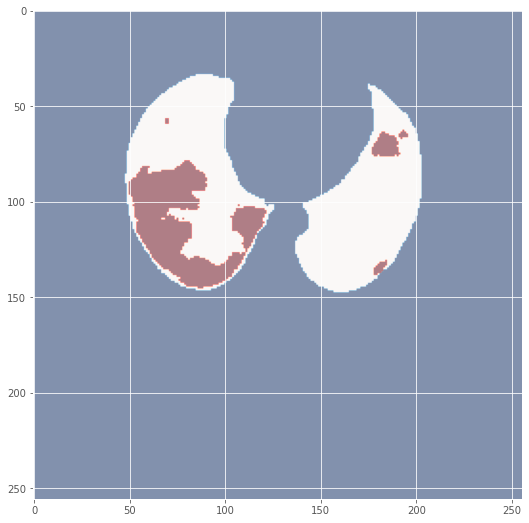

23.52%


In [18]:
ind = random.randint(0, len(test_x) - 1)

lungs_image = Preprocessor.binarize(lungs_prediction[ind].copy())
covid_image = Preprocessor.binarize(covid_prediction[ind].copy())

plt.figure(figsize=(9, 9))
plt.imshow(lungs_image, cmap='Blues_r')
plt.imshow(covid_image, alpha=0.5, cmap='Reds')
plt.show()

print(f'{Estimator.content(covid_prediction[ind], lungs_prediction[ind]):.2%}')

del ind, lungs_image, covid_image

In [22]:
@jit(nopython=True, parallel=True)
def confusion_matrix(ground_truth, predicted):
    TP, TN, FP, FN = 0, 0, 0, 0

    for i in range(len(ground_truth)):
        for y in range(len(ground_truth[i])):
            for x in range(len(ground_truth[i][y])):
                if ground_truth[i][y][x] < Const.MASK_THRESHOLD:
                    if predicted[i][y][x] < Const.MASK_THRESHOLD:
                        TN += 1
                    else:
                        FN += 1
                else:
                    if predicted[i][y][x] >= Const.MASK_THRESHOLD:
                        TP += 1
                    else:
                        FP += 1

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * recall * precision / (recall + precision)
    specifity = TN / (TN + FP)

    return TP, TN, FP, FN, accuracy, precision, recall, f1, specifity


def plot_confusion_matrix(ground_truth, predicted, model_name):
    TP, TN, FP, FN, accuracy, precision, recall, f1, specifity = confusion_matrix(ground_truth, predicted)
    matrix = np.array([[TN, FP], [FN, TP]])

    group_names = ['Истинно отрицательные (TN)', 'Ложно положительные (FP)', 'Ложно отрицательные (FN)',
                   'Истинно положительные (TP)']
    group_counts = [f'{value:0.0f}' for value in matrix.flatten()]
    group_percentages = [f'{value:.2%}' for value in matrix.flatten() / np.sum(matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    plt.figure(figsize=(9, 9))
    plt.title(f'Матрица ошибок модели сегментации {model_name}')
    sns.heatmap(matrix, fmt='', cmap='Blues', annot=labels)
    plt.show()

    print(f'Правильность модели сегментации {model_name} = {accuracy:.2%}')
    print(f'Точность модели сегментации {model_name} = {precision:.2%}')
    print(f'Отклик модели сегментации {model_name} = {recall:.2%}')
    print(f'Оценка F1 модели сегментации {model_name} = {f1:.2%}')
    print(f'Специфичность модели сегментации {model_name} = {specifity:.2%}')

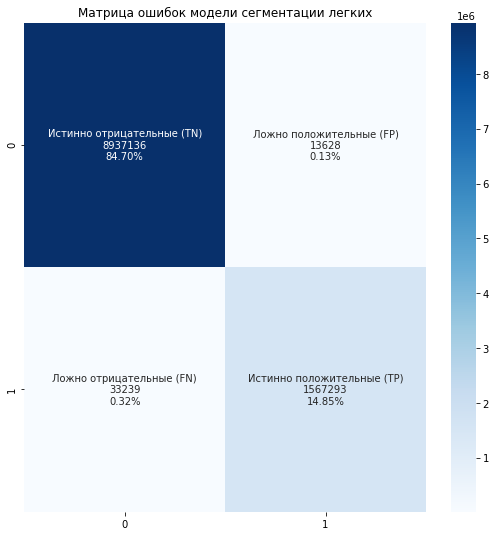

Правильность модели сегментации легких = 99.56%
Точность модели сегментации легких = 99.14%
Отклик модели сегментации легких = 97.92%
Оценка F1 модели сегментации легких = 98.53%
Специфичность модели сегментации легких = 99.85%


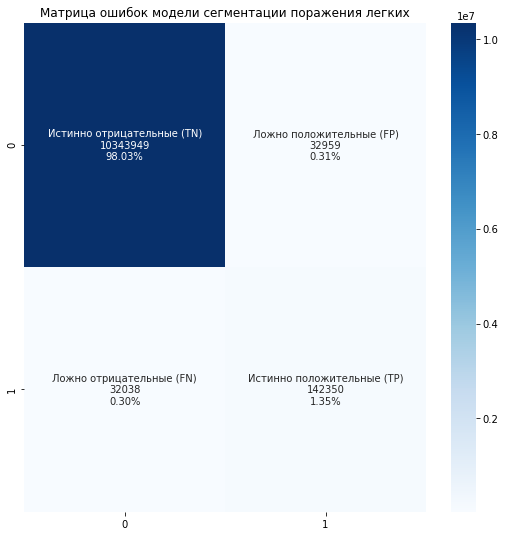

Правильность модели сегментации поражения легких = 99.38%
Точность модели сегментации поражения легких = 81.20%
Отклик модели сегментации поражения легких = 81.63%
Оценка F1 модели сегментации поражения легких = 81.41%
Специфичность модели сегментации поражения легких = 99.68%


In [23]:
plot_confusion_matrix(test_lungs, lungs_prediction, 'легких')
plot_confusion_matrix(test_covid, covid_prediction, 'поражения легких')